In [87]:
%load_ext autoreload 
%autoreload 2
import cv2
import json, os, cv2
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import seaborn as sns
import h5py as hf
from tqdm import tqdm
from tqdm import tqdm
import itertools 
from scipy.interpolate import interp1d
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import os, fnmatch

import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/obstacle_avoidance')

from utils.base_functions import *
from src.utils.auxiliary import flatten_series
from src.utils.path import find
from src.base import BaseInput
from plots import plot_oa

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
## take raw_df from multiple session and plt  
class plot_oa(BaseInput):

    def __init__(self,metadata_path,cluster=False,plot_trace=False):
        with open(metadata_path) as f:
            self.metadata = json.load(f)

        self.path = self.metadata['path']
        self.dates_list = [i for i in list(self.metadata.keys()) if i != 'path' ]
        
    def gather_session_df(self):
        # list data path files
        data_path = Path(self.path).expanduser()
        # find date
        hf_list = []
        df =pd.DataFrame()
        for date in self.dates_list:
            use_animals = [k for k,v in self.metadata[date].items()]
            for ani in use_animals:
                for task in os.listdir(data_path / date / ani):
                    h5_paths=[str(i) for i in list((data_path / date / ani/ task).rglob('*.h5'))]
                    raw_h5 = [i for i in h5_paths if 'raw' in i]
                    hf_list.append(raw_h5)
        hf_list = list(itertools.chain(*hf_list))
        for h5 in hf_list:
            data = pd.read_hdf(h5)
            df=df.append(data,ignore_index=True)
        self.df=df
        for ind, row in self.df.iterrows():
            self.df.at[ind,'exp'] = row['animal'] + '_' + row['date']
            #self.df = self.df.reset_index()
    def check_tracking(self,vid_path,num_trials,animal):
        frames = format_frames(vid_path)
        ## create animal df\
    def cluster(self):
        self.df = self.df[self.df['gt_obstacle_cen_x_cm'].notna()]


        kmeans_input = np.vstack([self.df['gt_obstacle_cen_x_cm'].values, self.df['gt_obstacle_cen_y_cm'].values])

        kmeans_input = np.transpose(kmeans_input)

        labels = KMeans(n_clusters=9).fit(kmeans_input).labels_
        self.df['obstacle_cluster'] = labels
    def plot_trace_cluster(self,savepath,filename):
        pdf = PdfPages(os.path.join(savepath,(filename) + '_figs.pdf'))
        plt.figure()
        plt.subplots(3,3, figsize=(25,21))

        for clusters, cluster_name in enumerate(self.df['obstacle_cluster'].unique()):
            x=self.df.loc[self.df['obstacle_cluster']==cluster_name]
            for i, row in x.iterrows():
                if row['odd'] == False:
                    plt.subplot(3,3,cluster_name+1)
                    plt.gca().set_aspect('equal', adjustable='box')
                    plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))

                    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                        [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


                    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                        [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')




                    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                    plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                    plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
                    sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
                    #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                    plt.ylim([0,52]); plt.xlim([0, 72])
        pdf.savefig(); plt.close()

        plt.figure()
        plt.subplots(3,3, figsize=(25,21))
        


        for clusters, cluster_name in enumerate(self.df['obstacle_cluster'].unique()):
            x=self.df.loc[self.df['obstacle_cluster']==cluster_name]
            for i, row in x.iterrows():
                if row['odd'] == True:
                    plt.subplot(3,3,cluster_name+1)
                    plt.gca().set_aspect('equal', adjustable='box')
                    plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))

                    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                        [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


                    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                        [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')




                    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                    plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                    plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
                    sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
                    #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                    plt.ylim([0,52]); plt.xlim([0, 72])
        pdf.savefig(); plt.close()
        pdf.close()







    
    #def cluster(self
        

                        



        


        

In [88]:
session = plot_oa('D:/obstacle_avoidance/metadata/J20RT.json')

In [89]:
session.gather_session_df()
df = session.df

In [90]:
session.process_df()
df = session.df
#df = df.reset_index()

In [130]:
df

,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,...,gt_obstacle_cen_y_cm,obstacle_cluster,body_angle,head_angle,obstacle_edge_mid_x_cm,obstacle_edge_mid_y_cm,obstacle_intersect_spine_x,obstacle_intersect_spine_y,obstacle_intersect_nose_x,obstacle_intersect_nose_y
0,56396.382105,56401.703283,"[56396.387507, 56396.404108, 56396.420454, 563...","[264, 265, 266, 267, 268, 269, 270, 271, 272, ...","[112.0492172241211, 111.85668182373047, 111.71...","[263.0643615722656, 262.69403076171875, 262.92...","[0.9999997615814209, 0.9999996423721313, 0.999...","[123.26714324951172, 122.17658996582031, 122.3...","[273.4779052734375, 273.4393615722656, 273.583...","[0.9999998807907104, 0.9999997615814209, 0.999...",...,25.057075,2,"[2.1246260435150037, 2.1738110547466842, 2.195...","[2.139470020555825, 2.161499328211793, 2.18585...",34.491650,25.015566,[],"[nan, nan]","[34.67776122806318, 34.688785739888935, 34.665...","[18.29728888711756, 17.899324537693015, 18.730..."
1,56401.703283,56405.103193,"[56401.705612, 56401.722419, 56401.73966, 5640...","[[583, 584, 585, 586, 587, 588, 589, 590, 591,...","[567.846923828125, 567.9541015625, 567.9830932...","[261.62213134765625, 261.7710266113281, 261.85...","[0.9999982118606567, 0.9999979734420776, 0.999...","[559.8572998046875, 560.25341796875, 560.58520...","[249.90591430664062, 250.23562622070312, 250.2...","[0.9999986886978149, 0.9999984502792358, 0.999...",...,25.126500,2,"[-1.2999146763347598, -1.1896132978595317, -1....","[-0.6894644651287857, -0.6745131003672536, -0....",39.287183,25.165562,[],[],[],[]
2,56405.103193,56415.839680,"[56405.106944, 56405.123494, 56405.141068, 564...","[787, 788, 789, 790, 791, 792, 793, 794, 795, ...","[112.341796875, 112.5261459350586, 112.2376403...","[262.132080078125, 261.9194030761719, 262.1935...","[0.9999998807907104, 0.9999998807907104, 0.999...","[124.35699462890625, 124.48033905029297, 124.6...","[271.0626525878906, 270.6658020019531, 271.431...","[0.9999998807907104, 0.9999998807907104, 0.999...",...,26.106244,1,"[1.504031652371819, 1.6451124501240244, 1.7814...","[1.896738727311622, 1.9824265600299151, 2.1122...",25.633600,26.022333,"[19.78460906107649, 18.701065636148265, 18.841...","[19.78460906107649, 18.701065636148265, 18.841...","[25.56787043325944, 25.568659346605266, 25.574...","[19.643672204018085, 19.7202311411273, 20.3008..."
3,56415.839680,56420.066956,"[56415.843865, 56415.861337, 56415.877235, 564...","[[1431, 1432, 1433, 1434, 1435, 1436, 1437, 14...","[569.6924438476562, 570.3181762695312, 570.292...","[260.84686279296875, 260.5827941894531, 260.42...","[0.9999996423721313, 0.9999996423721313, 0.999...","[554.6183471679688, 554.9428100585938, 555.338...","[254.00350952148438, 254.08241271972656, 254.0...","[0.9999994039535522, 0.9999994039535522, 0.999...",...,26.059246,1,"[-1.4319919350447348, -1.4718576645426058, -1....","[-0.9243926671891026, -0.9557880470971687, -0....",30.256760,26.125097,[],[],[],[]
4,56420.066956,56430.414502,"[56420.078784, 56420.095475, 56420.112051, 564...","[1685, 1686, 1687, 1688, 1689, 1690, 1691, 169...","[112.79441833496094, 113.09716796875, 113.1911...","[262.7314453125, 263.1336364746094, 263.659088...","[0.9999998807907104, 0.9999998807907104, 0.999...","[122.4262924194336, 122.25873565673828, 122.77...","[274.2384338378906, 274.76898193359375, 275.10...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.9999998807907104, ...",...,24.342578,2,"[1.830537085766586, 1.855315385639942, 1.89012...","[1.9488516156456273, 2.006736025827992, 2.0131...",35.462923,24.341283,"[31.396283878271017, 29.984545478654432, 28.22...","[31.396283878271017, 29.984545478654432, 28.22...","[35.42679981163795, 35.455677718418805, 35.507...","[27.556498441424214, 24.986170537821444, 20.39..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,55875.372928,55878.572134,"[55875.3744, 55875.391129, 55875.407769, 55875...","[[17293

In [121]:
cluster

5

In [123]:
df

,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,...,gt_obstacle_cen_y_cm,obstacle_cluster,body_angle,head_angle,obstacle_edge_mid_x_cm,obstacle_edge_mid_y_cm,obstacle_intersect_spine_x,obstacle_intersect_spine_y,obstacle_intersect_nose_x,obstacle_intersect_nose_y
0,56396.382105,56401.703283,"[56396.387507, 56396.404108, 56396.420454, 563...","[264, 265, 266, 267, 268, 269, 270, 271, 272, ...","[112.0492172241211, 111.85668182373047, 111.71...","[263.0643615722656, 262.69403076171875, 262.92...","[0.9999997615814209, 0.9999996423721313, 0.999...","[123.26714324951172, 122.17658996582031, 122.3...","[273.4779052734375, 273.4393615722656, 273.583...","[0.9999998807907104, 0.9999997615814209, 0.999...",...,25.057075,2,"[2.1246260435150037, 2.1738110547466842, 2.195...","[2.139470020555825, 2.161499328211793, 2.18585...",34.491650,25.015566,[],"[nan, nan]","[34.67776122806318, 34.688785739888935, 34.665...","[18.29728888711756, 17.899324537693015, 18.730..."
1,56401.703283,56405.103193,"[56401.705612, 56401.722419, 56401.73966, 5640...","[[583, 584, 585, 586, 587, 588, 589, 590, 591,...","[567.846923828125, 567.9541015625, 567.9830932...","[261.62213134765625, 261.7710266113281, 261.85...","[0.9999982118606567, 0.9999979734420776, 0.999...","[559.8572998046875, 560.25341796875, 560.58520...","[249.90591430664062, 250.23562622070312, 250.2...","[0.9999986886978149, 0.9999984502792358, 0.999...",...,25.126500,2,"[-1.2999146763347598, -1.1896132978595317, -1....","[-0.6894644651287857, -0.6745131003672536, -0....",39.287183,25.165562,[],[],[],[]
2,56405.103193,56415.839680,"[56405.106944, 56405.123494, 56405.141068, 564...","[787, 788, 789, 790, 791, 792, 793, 794, 795, ...","[112.341796875, 112.5261459350586, 112.2376403...","[262.132080078125, 261.9194030761719, 262.1935...","[0.9999998807907104, 0.9999998807907104, 0.999...","[124.35699462890625, 124.48033905029297, 124.6...","[271.0626525878906, 270.6658020019531, 271.431...","[0.9999998807907104, 0.9999998807907104, 0.999...",...,26.106244,1,"[1.504031652371819, 1.6451124501240244, 1.7814...","[1.896738727311622, 1.9824265600299151, 2.1122...",25.633600,26.022333,"[19.78460906107649, 18.701065636148265, 18.841...","[19.78460906107649, 18.701065636148265, 18.841...","[25.56787043325944, 25.568659346605266, 25.574...","[19.643672204018085, 19.7202311411273, 20.3008..."
3,56415.839680,56420.066956,"[56415.843865, 56415.861337, 56415.877235, 564...","[[1431, 1432, 1433, 1434, 1435, 1436, 1437, 14...","[569.6924438476562, 570.3181762695312, 570.292...","[260.84686279296875, 260.5827941894531, 260.42...","[0.9999996423721313, 0.9999996423721313, 0.999...","[554.6183471679688, 554.9428100585938, 555.338...","[254.00350952148438, 254.08241271972656, 254.0...","[0.9999994039535522, 0.9999994039535522, 0.999...",...,26.059246,1,"[-1.4319919350447348, -1.4718576645426058, -1....","[-0.9243926671891026, -0.9557880470971687, -0....",30.256760,26.125097,[],[],[],[]
4,56420.066956,56430.414502,"[56420.078784, 56420.095475, 56420.112051, 564...","[1685, 1686, 1687, 1688, 1689, 1690, 1691, 169...","[112.79441833496094, 113.09716796875, 113.1911...","[262.7314453125, 263.1336364746094, 263.659088...","[0.9999998807907104, 0.9999998807907104, 0.999...","[122.4262924194336, 122.25873565673828, 122.77...","[274.2384338378906, 274.76898193359375, 275.10...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.9999998807907104, ...",...,24.342578,2,"[1.830537085766586, 1.855315385639942, 1.89012...","[1.9488516156456273, 2.006736025827992, 2.0131...",35.462923,24.341283,"[31.396283878271017, 29.984545478654432, 28.22...","[31.396283878271017, 29.984545478654432, 28.22...","[35.42679981163795, 35.455677718418805, 35.507...","[27.556498441424214, 24.986170537821444, 20.39..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,55875.372928,55878.572134,"[55875.3744, 55875.391129, 55875.407769, 55875...","[[17293

In [129]:
cluster[0]

2

In [128]:
cluster = df['obstacle_cluster'].tolist()

for ind,value in enumerate(cluster):
    if value
   

(0.0, 72.0)

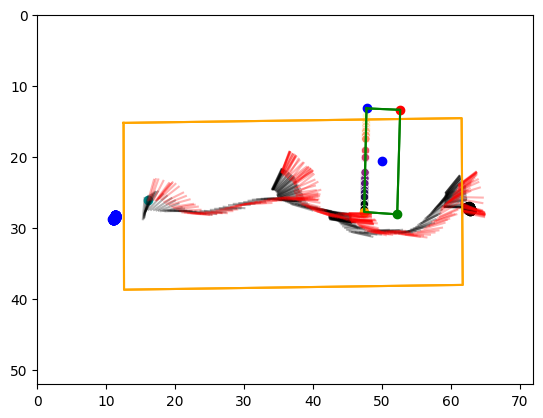

In [110]:
plt.plot([test['arenaTL_x_cm'], test['arenaTR_x_cm'], test['arenaBR_x_cm'], test['arenaBL_x_cm'],test['arenaTL_x_cm']],
                [test['arenaTL_y_cm'], test['arenaTR_y_cm'], test['arenaBR_y_cm'], test['arenaBL_y_cm'],test['arenaTL_y_cm']],color='orange')


plt.plot([test['gt_obstacleTL_x_cm'], test['gt_obstacleTR_x_cm'], test['gt_obstacleBR_x_cm'], test['gt_obstacleBL_x_cm'],test['gt_obstacleTL_x_cm']],
                [test['gt_obstacleTL_y_cm'], test['gt_obstacleTR_y_cm'], test['gt_obstacleBR_y_cm'], test['gt_obstacleBL_y_cm'],test['gt_obstacleTL_y_cm']],color='green')



for ind,i in enumerate(test['body_angle']):

    current_ang = i
    x1 = test['ts_spine_x_cm'][ind]
    y1 = test['ts_spine_y_cm'][ind]
    x2 = x1-3 * np.cos(current_ang)
    y2 = y1-3* np.sin(current_ang)
    plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
    #plt.scatter(x1,y1,color = 'r',marker = '.')
    #plt.scatter(x2,y2,color = 'b',marker = '<')
    #sns.scatterplot(x=(x1,x2),y=(y1,y2),hue = enumerate(test['ts_nose_x_cm']),palette ='magma',legend=False)
for ind,i in enumerate(test['head_angle']):

    current_ang = i
    x1 = test['ts_nose_x_cm'][ind]
    y1 = test['ts_nose_y_cm'][ind]
    x2 = x1-3 * np.cos(current_ang)
    y2 = y1-3* np.sin(current_ang)
    plt.plot((x1,x2), (y1,y2), '-',color = 'red',alpha=0.3)
plt.plot([test['arenaTL_x_cm'], test['arenaTR_x_cm'], test['arenaBR_x_cm'], test['arenaBL_x_cm'],test['arenaTL_x_cm']],
                [test['arenaTL_y_cm'], test['arenaTR_y_cm'], test['arenaBR_y_cm'], test['arenaBL_y_cm'],test['arenaTL_y_cm']],color='orange')


plt.plot([test['gt_obstacleTL_x_cm'], test['gt_obstacleTR_x_cm'], test['gt_obstacleBR_x_cm'], test['gt_obstacleBL_x_cm'],test['gt_obstacleTL_x_cm']],
                [test['gt_obstacleTL_y_cm'], test['gt_obstacleTR_y_cm'], test['gt_obstacleBR_y_cm'], test['gt_obstacleBL_y_cm'],test['gt_obstacleTL_y_cm']],color='green')

sns.scatterplot(x=test['obstacle_intersect_nose_x'],y=test['obstacle_intersect_nose_y'],hue = test['obstacle_intersect_nose_x'], palette ='magma',legend=False)    
plt.scatter(test['gt_obstacleTL_x_cm'],test['gt_obstacleTL_y_cm'],color = 'blue')
plt.scatter(test['gt_obstacleTR_x_cm'],test['gt_obstacleTR_y_cm'],color = 'red')
plt.scatter(test['gt_obstacleBL_x_cm'],test['gt_obstacleBL_y_cm'],color = 'orange')
plt.scatter(test['gt_obstacleBR_x_cm'],test['gt_obstacleBR_y_cm'],color = 'green')
plt.scatter(test['gt_obstacle_cen_x_cm'],test['gt_obstacle_cen_y_cm'],color='blue')
plt.scatter(test['leftportT_x_cm'],test['leftportT_y_cm'],color='blue')
plt.scatter(test['rightportT_x_cm'],test['rightportT_y_cm'],color='black')
#sns.scatterplot(x=test['ts_nose_x_cm'],y=test['ts_nose_y_cm'],hue = enumerate(test['ts_nose_x_cm']), palette ='magma',legend=False) 
plt.scatter(test['ts_nose_x_cm'][0],test['ts_nose_y_cm'][0],color='c')  
#plt.scatter(test['wobstacle_x_cm'], test['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ test['obstacle_cluster']])
plt.ylim([52,0]); plt.xlim([0, 72])

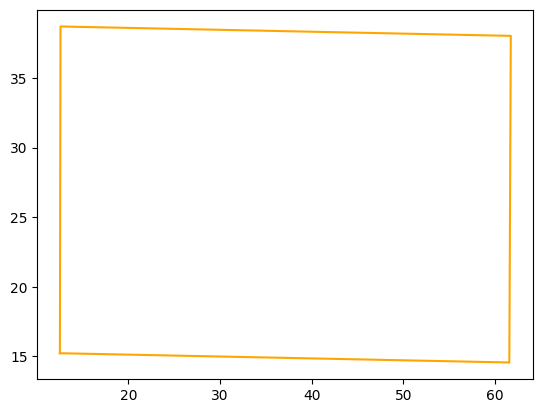

In [102]:
plt.plot([test['arenaTL_x_cm'], test['arenaTR_x_cm'], test['arenaBR_x_cm'], test['arenaBL_x_cm'],test['arenaTL_x_cm']],
                [test['arenaTL_y_cm'], test['arenaTR_y_cm'], test['arenaBR_y_cm'], test['arenaBL_y_cm'],test['arenaTL_y_cm']],color='orange')

In [101]:
test['obstacle_intersect_nose_x']

array([47.72741738435847, 47.643471765946, 47.55304043962686,
       47.56177686258173, 47.53204420614294, 47.48038390924688,
       47.452609096746, 47.475150798469585, 47.51494435933766,
       47.55360492278294, 47.546121689012196, 47.542038839213006,
       47.530230607554444, 47.49032008540009, 47.48121221030776,
       47.49761586294019, 47.493365402278826, 47.51667612907544,
       47.51908690483382, 47.475563157238454, 47.510216475157534,
       47.49190349955036, 47.48277349390635, 47.48608704664826,
       47.50140207081097, 47.497684783240395, 47.492732271478246,
       47.480013589257766, 47.48902606420781, 47.51323261904491,
       47.52304741056161, 47.55201470864467, 47.6184770004702,
       47.6994384056956, 47.75693246317591, 47.73494769478035,
       47.723967762053, 47.71355669350402, 47.707694395261086,
       47.68907190170094, 47.69090549431855, 47.69424991752142,
       47.68156194401634, 47.62068054614939, 47.57138205350248,
       47.535739121150414, 47.5137556

In [48]:
for ind,row in df.iterrows():
     if row['odd'] == False:
        obstacle_top= (row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'])
        obstacle_bottom=(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'])
        edge_mid = midpoint(obstacle_top[0],obstacle_top[1],obstacle_bottom[0],obstacle_bottom[1])
        df.at[ind,'obstacle_edge_mid_x_cm'] = edge_mid[0]
        df.at[ind,'obstacle_edge_mid_y_cm'] = edge_mid[1]
     if row['odd'] == True:
         obstacle_top= (row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'])
         obstacle_bottom=(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'])
         edge_mid = midpoint(obstacle_top[0],obstacle_top[1],obstacle_bottom[0],obstacle_bottom[1])
         df.at[ind,'obstacle_edge_mid_x_cm'] = edge_mid[0]
         df.at[ind,'obstacle_edge_mid_y_cm'] = edge_mid[1]
         


    

In [32]:
intersect_list = list_columns(df,['intersect'])
intersect_list

array(['obstacle_intersect_spine_x', 'obstacle_intersect_spine_y',
       'obstacle_intersect_nose_x', 'obstacle_intersect_nose_y'],
      dtype='<U26')

In [33]:
for ind,row in df.iterrows():
    for key in intersect_list:
        if 'x' in key:
            
        if 'y' in key:  
        



SyntaxError: unexpected EOF while parsing (2057502496.py, line 4)

In [72]:
df.at[2,'obstacle_edge_mid_y_cm']

26.0223326116436

In [73]:
df.at[2,'obstacle_intersect_nose_y'] -  df.at[2,'obstacle_edge_mid_y_cm']

array([-6.378660407625514, -6.302101470516298, -5.721523351724425,
       -6.583477699961929, -7.091776636008227, -6.469721775951591,
       -6.4343822357262255, -5.696431023141418, -6.203117038687985,
       -5.458696804279498, -4.5744801335850305, -4.167961209477653,
       -3.7855365461272257, -3.5679398045826076, -4.148018502736477,
       -4.628285625666219, -5.271572195330812, -5.008237165472448,
       -5.487984023798344, -6.466636264974074, 5.8757245875471575,
       3.642312909597223, 3.0397626146894154, 2.1644379661005644,
       1.7866939714123014, 0.5371217801042469, -0.8094720120825301,
       -1.4850385344095756, -1.567349670452252, -1.94331960680314,
       -3.1210373480867517, -3.916002568944055, -4.853481355590652,
       -5.848981356862719, -5.713650406733134, -5.804698151797144,
       -6.582856671309475, -6.142867855857332, -6.351327643286144,
       -6.90083224124994, -7.334232432519443, -7.30517280412176,
       -7.279291517528758, -6.78414745533728], dtype=object

(array([16., 10.,  7.,  1.,  4.,  1.,  1.,  2.,  1.,  1.]),
 array([18.68810018, 20.00909588, 21.33009158, 22.65108729, 23.97208299,
        25.29307869, 26.61407439, 27.93507009, 29.2560658 , 30.5770615 ,
        31.8980572 ]),
 <BarContainer object of 10 artists>)

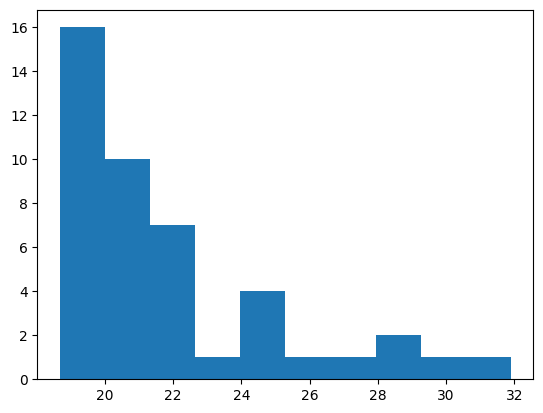

In [70]:
plt.hist(df.at[2,'obstacle_intersect_nose_y']) 

(array([16., 10.,  7.,  1.,  4.,  1.,  1.,  2.,  1.,  1.]),
 array([-7.33423243, -6.01323673, -4.69224103, -3.37124533, -2.05024962,
        -0.72925392,  0.59174178,  1.91273748,  3.23373318,  4.55472889,
         5.87572459]),
 <BarContainer object of 10 artists>)

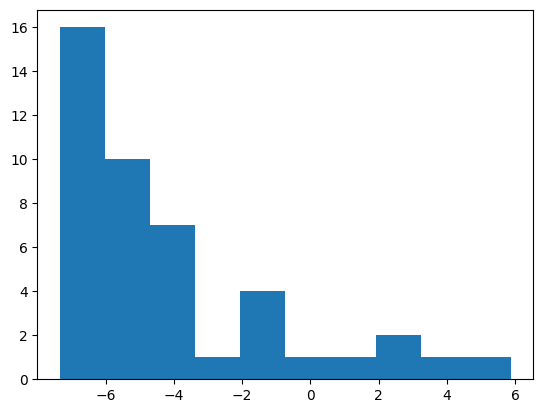

In [74]:
plt.hist((df.at[2,'obstacle_intersect_nose_y'] -  df.at[2,'obstacle_edge_mid_y_cm']))



In [86]:
savepath = 'D:obstacle_avoidance/figures/tracking_oa'
filename = 'J20RT_intersect_hist_112222'
pdf = PdfPages(os.path.join(savepath,(filename) + '_figs.pdf'))
for cluster_num,cluster in enumerate(df['obstacle_cluster'].unique()):
    #fig, ax = plt.subplots(,5, figsize=(25,21),dpi = 50)
    x = df.loc[df['obstacle_cluster']==cluster]
    x = x.reset_index()
    y = nearestX_roundup(len(x),4)
    fig, ax = plt.subplots(int((y/4)),4, figsize=(25,len(x)),dpi = 100)
    fig.suptitle(str(x['obstacle_cluster'].unique()) + '_' +str(x['animal'].unique()) , size = 20)
    for ind,row in x.iterrows():
        plt.subplot(int((y/4)),4,ind+1)
        #plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().set_title(str(row['odd']) + str(ind))
        plt.hist((row['obstacle_intersect_nose_y'] -  row['obstacle_edge_mid_y_cm']) )
        plt.xlim(8,-8)
        
    pdf.savefig(); plt.close()
pdf.close()

In [57]:
 df.at[2,'obstacle_edge_mid_x_cm']

25.633600320769588

In [81]:
df.at[2,'obstacle_intersect_nose_y'] 

array([19.643672204018085, 19.7202311411273, 20.300809259919173,
       19.43885491168167, 18.93055597563537, 19.552610835692008,
       19.587950375917373, 20.32590158850218, 19.819215572955613,
       20.5636358073641, 21.447852478058568, 21.854371402165945,
       22.236796065516373, 22.45439280706099, 21.87431410890712,
       21.39404698597738, 20.750760416312787, 21.01409544617115,
       20.534348587845255, 19.555696346669524, 31.898057199190756,
       29.66464552124082, 29.062095226333014, 28.186770577744163,
       27.8090265830559, 26.559454391747845, 25.21286059956107,
       24.537294077234023, 24.454982941191346, 24.07901300484046,
       22.901295263556847, 22.106330042699543, 21.168851256052946,
       20.17335125478088, 20.308682204910465, 20.217634459846455,
       19.439475940334123, 19.879464755786266, 19.671004968357455,
       19.121500370393658, 18.688100179124156, 18.71715980752184,
       18.74304109411484, 19.23818515630632], dtype=object)

In [82]:
df.at[2,'obstacle_edge_mid_y_cm'] 

26.0223326116436

In [56]:
df.at[2,'obstacle_intersect_nose_x']

array([25.56787043325944, 25.568659346605266, 25.574642003150743,
       25.565759861959968, 25.560522017373053, 25.566932077379974,
       25.56729623910912, 25.574900570911012, 25.56967934691153,
       25.577350339744047, 25.586461886461578, 25.590650923256888,
       25.59459167703539, 25.59683393613531, 25.590856425946633,
       25.585907439490597, 25.579278594065578, 25.58199217039414,
       25.577048545084757, 25.56696387250254, 25.69414762874641,
       25.671133094506587, 25.664924022291967, 25.655904104784238,
       25.65201158367607, 25.639135174787413, 25.625258991885985,
       25.618297512722574, 25.617449324957875, 25.61357508490678,
       25.601439111253015, 25.593247269831426, 25.58358687544583,
       25.573328592527723, 25.574723131123637, 25.573784915627172,
       25.565766261445262, 25.570300193885185, 25.568152087934646,
       25.562489633265123, 25.55802359431673, 25.5583230437283,
       25.558589741427763, 25.5636920295932], dtype=object)

In [54]:
df.at[2,'obstacle_intersect_nose_x']

array([19.643672204018085, 19.7202311411273, 20.300809259919173,
       19.43885491168167, 18.93055597563537, 19.552610835692008,
       19.587950375917373, 20.32590158850218, 19.819215572955613,
       20.5636358073641, 21.447852478058568, 21.854371402165945,
       22.236796065516373, 22.45439280706099, 21.87431410890712,
       21.39404698597738, 20.750760416312787, 21.01409544617115,
       20.534348587845255, 19.555696346669524, 31.898057199190756,
       29.66464552124082, 29.062095226333014, 28.186770577744163,
       27.8090265830559, 26.559454391747845, 25.21286059956107,
       24.537294077234023, 24.454982941191346, 24.07901300484046,
       22.901295263556847, 22.106330042699543, 21.168851256052946,
       20.17335125478088, 20.308682204910465, 20.217634459846455,
       19.439475940334123, 19.879464755786266, 19.671004968357455,
       19.121500370393658, 18.688100179124156, 18.71715980752184,
       18.74304109411484, 19.23818515630632], dtype=object)

In [42]:
~np.isnan(df.at[2,'obstacle_intersect_nose_x'].astype('float64'))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False,  True,  True,  True])

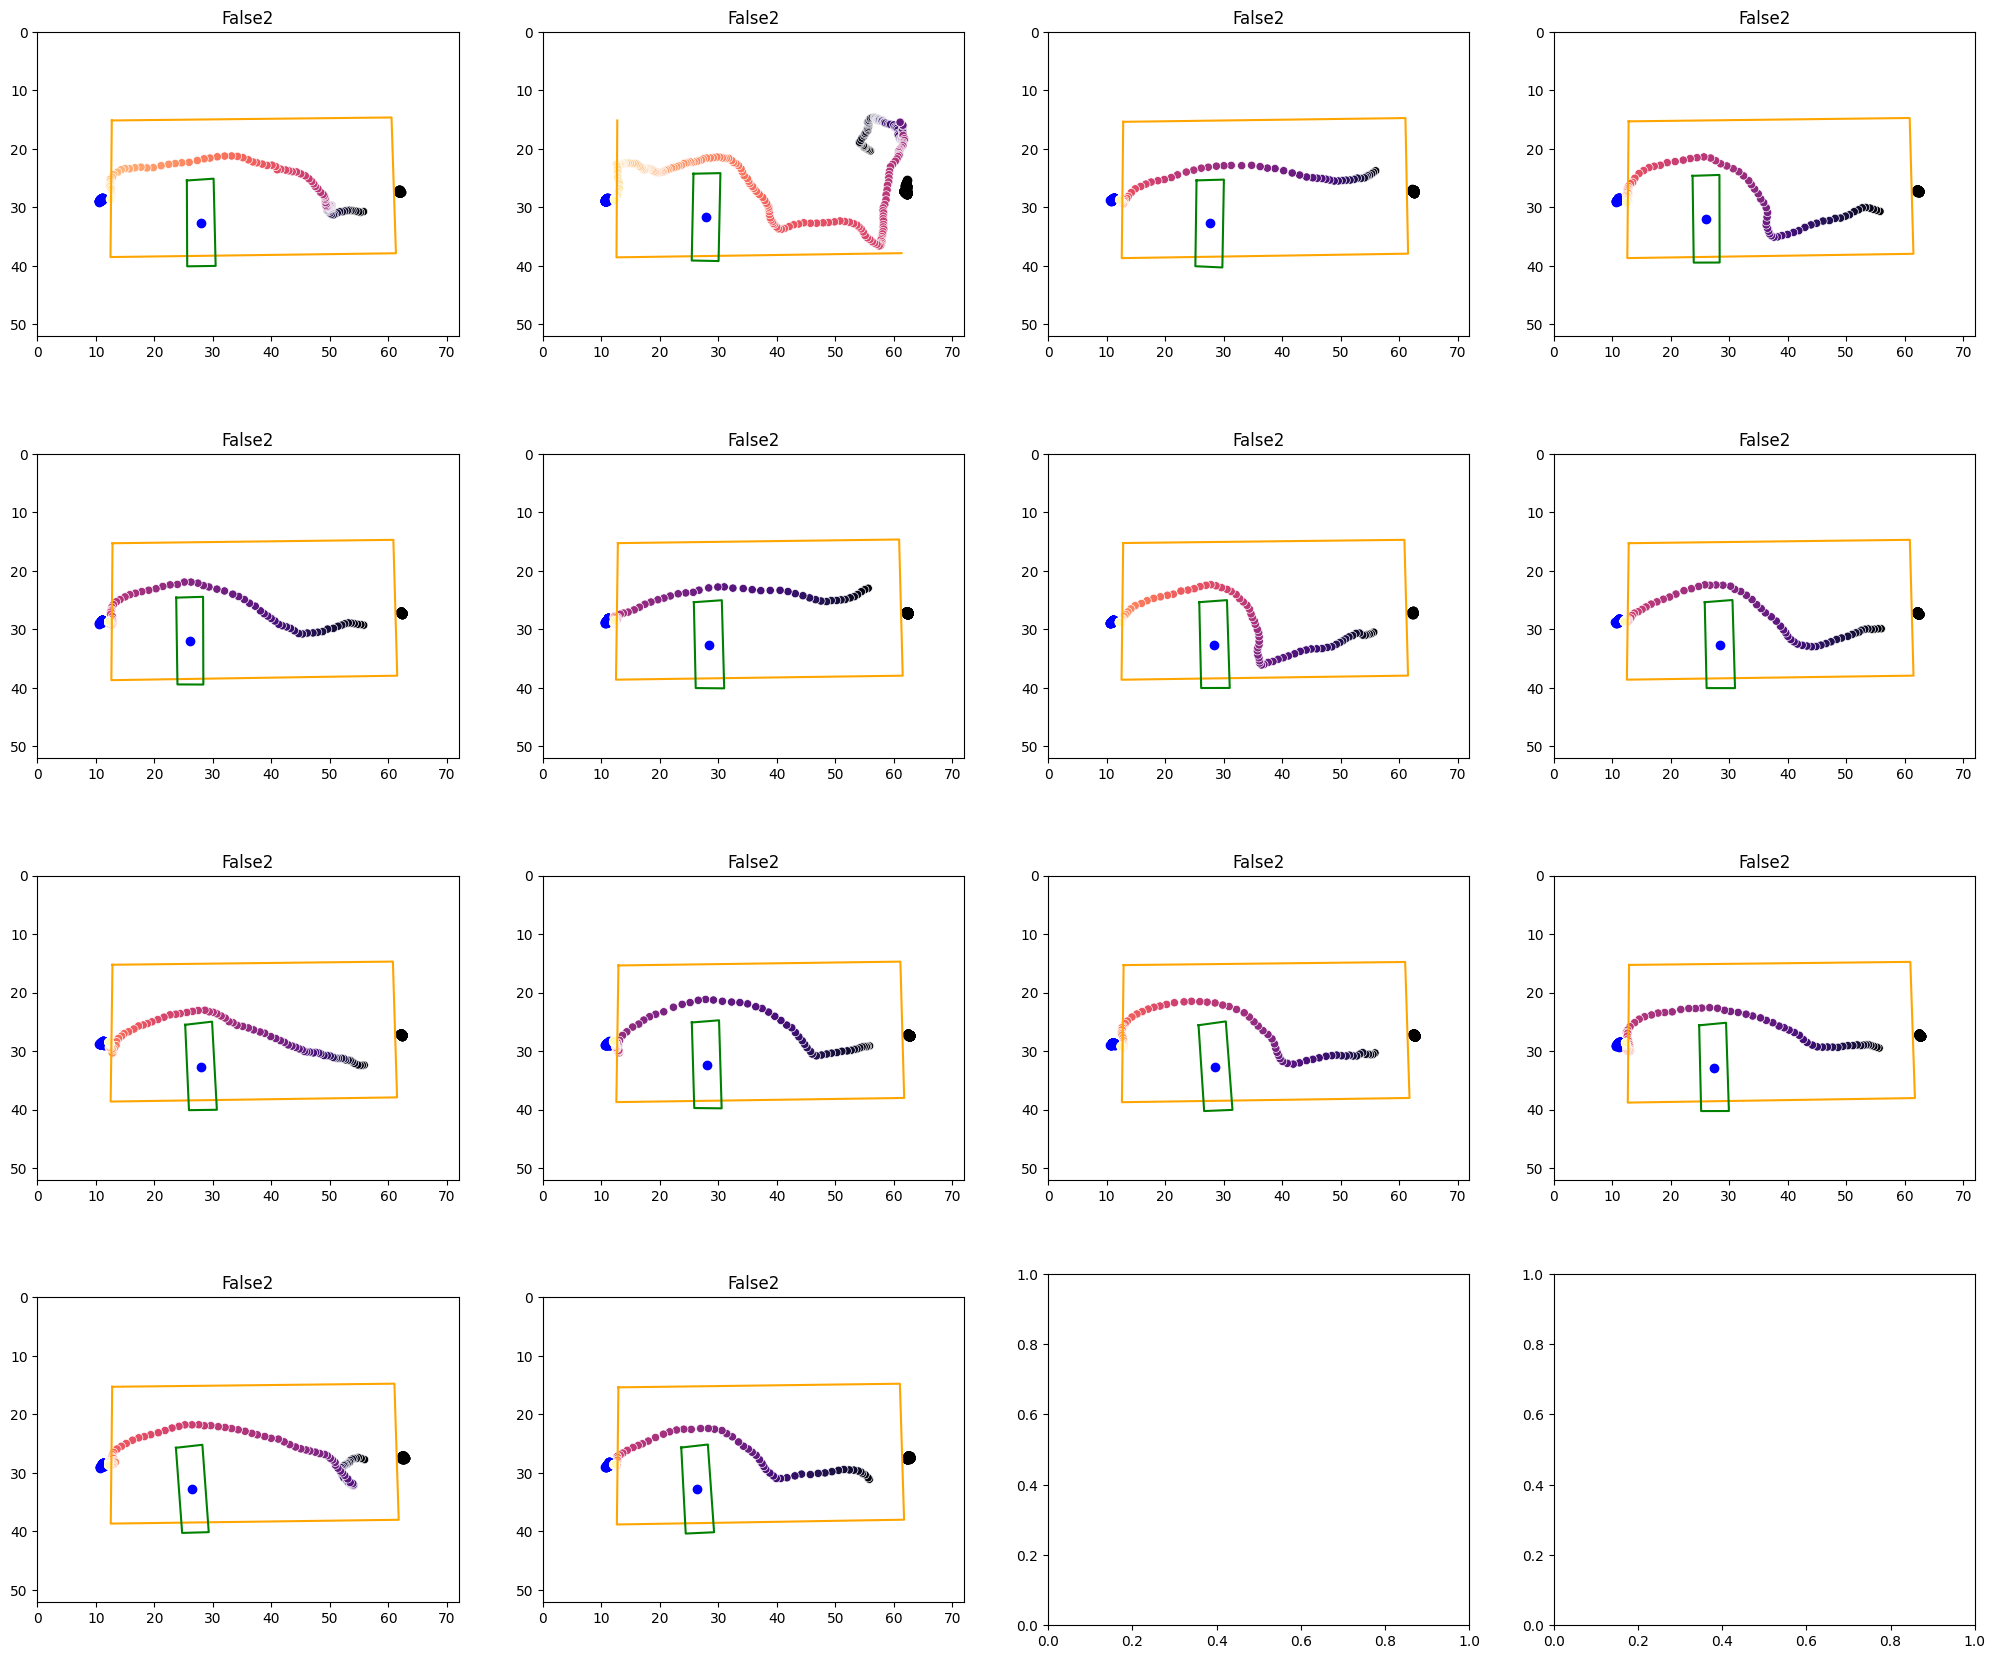

In [202]:
plt.subplots(4,4, figsize=(25,21))
for ind, row in cluster_2_even.iterrows():
    plt.subplot(4,4,ind+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))

    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
        [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')
    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
        [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')




    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
    plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
    plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
    sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False)
    plt.ylim([52,0]); plt.xlim([0, 72]) 


In [246]:
for ind, row in cluster_2_even.iterrows():
    temp_time = np.diff(row['trial_timestamps'])
    x = np.diff(row['nose_x_cm']); y = np.diff(row['nose_y_cm'])
    if len(x) == len(temp_time):
        xspeed = list((x/temp_time)**2)
    elif len(x) > len(temp_time):
        xspeed = list((x[:len(temp_time)]/temp_time)**2)
    elif len(x) < len(temp_time):
        xspeed = list((x/temp_time[:len(x)])**2)
    if len(y) == len(temp_time):
        yspeed = list((y/temp_time)**2)
    elif len(y) > len(temp_time):
        yspeed = list((y[:len(temp_time)]/temp_time)**2)
    elif len(y) < len(temp_time):
        yspeed = list((y/temp_time[:len(y)])**2)
    cluster_2_even.at[ind, 'speed'] = np.sqrt(xspeed + yspeed).astype(object)

(0.0, 72.0)

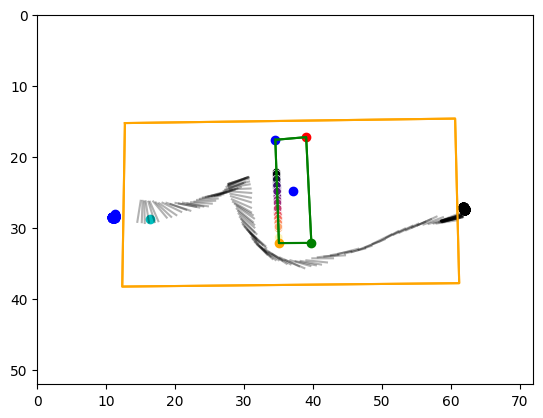

In [512]:
plt.plot([df.at[65,'arenaTL_x_cm'], df.at[65,'arenaTR_x_cm'], df.at[65,'arenaBR_x_cm'], df.at[65,'arenaBL_x_cm'],df.at[65,'arenaTL_x_cm']],
                [df.at[65,'arenaTL_y_cm'], df.at[65,'arenaTR_y_cm'], df.at[65,'arenaBR_y_cm'], df.at[65,'arenaBL_y_cm'],df.at[65,'arenaTL_y_cm']],color='orange')


plt.plot([df.at[65,'gt_obstacleTL_x_cm'], df.at[65,'gt_obstacleTR_x_cm'], df.at[65,'gt_obstacleBR_x_cm'], df.at[65,'gt_obstacleBL_x_cm'],df.at[65,'gt_obstacleTL_x_cm']],
                [df.at[65,'gt_obstacleTL_y_cm'], df.at[65,'gt_obstacleTR_y_cm'], df.at[65,'gt_obstacleBR_y_cm'], df.at[65,'gt_obstacleBL_y_cm'],df.at[65,'gt_obstacleTL_y_cm']],color='green')



for ind,i in enumerate(df.at[65,'body_angle']):

    current_ang = i
    x1 = df.at[65,'ts_spine_x_cm'][ind]
    y1 = df.at[65,'ts_spine_y_cm'][ind]
    x2 = x1-3 * np.cos(current_ang)
    y2 = y1-3* np.sin(current_ang)
    plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
    #plt.scatter(x1,y1,color = 'r',marker = '.')
    #plt.scatter(x2,y2,color = 'b',marker = '<')
    #sns.scatterplot(x=(x1,x2),y=(y1,y2),hue = enumerate(df.at[65,'ts_nose_x_cm']),palette ='magma',legend=False)
plt.plot([df.at[65,'arenaTL_x_cm'], df.at[65,'arenaTR_x_cm'], df.at[65,'arenaBR_x_cm'], df.at[65,'arenaBL_x_cm'],df.at[65,'arenaTL_x_cm']],
                [df.at[65,'arenaTL_y_cm'], df.at[65,'arenaTR_y_cm'], df.at[65,'arenaBR_y_cm'], df.at[65,'arenaBL_y_cm'],df.at[65,'arenaTL_y_cm']],color='orange')


plt.plot([df.at[65,'gt_obstacleTL_x_cm'], df.at[65,'gt_obstacleTR_x_cm'], df.at[65,'gt_obstacleBR_x_cm'], df.at[65,'gt_obstacleBL_x_cm'],df.at[65,'gt_obstacleTL_x_cm']],
                [df.at[65,'gt_obstacleTL_y_cm'], df.at[65,'gt_obstacleTR_y_cm'], df.at[65,'gt_obstacleBR_y_cm'], df.at[65,'gt_obstacleBL_y_cm'],df.at[65,'gt_obstacleTL_y_cm']],color='green')

sns.scatterplot(x=df.at[65,'obstacle_intersect_x'],y=df.at[65,'obstacle_intersect_y'],hue = df.at[65,'obstacle_intersect_x'], palette ='magma',legend=False)    
plt.scatter(df.at[65,'gt_obstacleTL_x_cm'],df.at[65,'gt_obstacleTL_y_cm'],color = 'blue')
plt.scatter(df.at[65,'gt_obstacleTR_x_cm'],df.at[65,'gt_obstacleTR_y_cm'],color = 'red')
plt.scatter(df.at[65,'gt_obstacleBL_x_cm'],df.at[65,'gt_obstacleBL_y_cm'],color = 'orange')
plt.scatter(df.at[65,'gt_obstacleBR_x_cm'],df.at[65,'gt_obstacleBR_y_cm'],color = 'green')
plt.scatter(df.at[65,'gt_obstacle_cen_x_cm'],df.at[65,'gt_obstacle_cen_y_cm'],color='blue')
plt.scatter(df.at[65,'leftportT_x_cm'],df.at[65,'leftportT_y_cm'],color='blue')
plt.scatter(df.at[65,'rightportT_x_cm'],df.at[65,'rightportT_y_cm'],color='black')
#sns.scatterplot(x=df.at[65,'ts_nose_x_cm'],y=df.at[65,'ts_nose_y_cm'],hue = enumerate(df.at[65,'ts_nose_x_cm']), palette ='magma',legend=False) 
plt.scatter(df.at[65,'ts_nose_x_cm'][0],df.at[65,'ts_nose_y_cm'][0],color='c')  
#plt.scatter(df.at[65,'wobstacle_x_cm'], df.at[65,'wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ df.at[65,'obstacle_cluster']])
plt.ylim([52,0]); plt.xlim([0, 72])

In [489]:
def nearestX_roundup(num, x):
  d = num // x 
  a = d * x
  b = a + x

  if (num/x).is_integer() == True:
    return num
  else:  
    return b

In [84]:
## Plot head agle by cluster
savepath = 'D:obstacle_avoidance/figures/tracking_oa'
filename = 'J20RT_headangle_112122'
pdf = PdfPages(os.path.join(savepath,(filename) + '_figs.pdf'))
for cluster_num,cluster in enumerate(df['obstacle_cluster'].unique()):
    #fig, ax = plt.subplots(,5, figsize=(25,21),dpi = 50)
    x = df.loc[df['obstacle_cluster']==cluster]
    x = x.reset_index()
    y = nearestX_roundup(len(x),4)
    fig, ax = plt.subplots(int((y/4)),4, figsize=(25,len(x)),dpi = 100)
    fig.suptitle(str(x['obstacle_cluster'].unique()) + '_' +str(x['animal'].unique()) , size = 20)
    for ind,row in x.iterrows():
        plt.subplot(int((y/4)),4,ind+1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().set_title(str(row['odd'])+ str(ind))
        for indx,i in enumerate(row['head_angle']):
            current_ang = i
            x1 = row['ts_nose_x_cm'][indx]
            y1 = row['ts_nose_y_cm'][indx]
            x2 = x1+3 * np.cos(current_ang)
            y2 = y1+3* np.sin(current_ang)
            plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
        plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')


        plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')

        sns.scatterplot(x=row['obstacle_intersect_nose_x'],y=row['obstacle_intersect_nose_y'],hue = row['obstacle_intersect_nose_x'], palette ='magma',legend=False)    
        plt.scatter(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'],color = 'blue')
        plt.scatter(row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'],color = 'red')
        plt.scatter(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'],color = 'orange')
        plt.scatter(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'],color = 'green')
        plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
        plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
        plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
        #sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
        plt.scatter(row['ts_nose_x_cm'][0],row['ts_nose_y_cm'][0],color='c')  
        #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
        plt.ylim([52,0]); plt.xlim([0, 72])
    pdf.savefig(); plt.close()
pdf.close()
#obstacle_intersect_nose

    #fig, ax = plt.subplots((y/5),5, figsize=(25,21),dpi = 50)

In [79]:
print(row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm'])

13.025729093246978 12.79985316813332 27.78111973069334 27.617286843833618 13.025729093246978


In [519]:
def midpoint(x1, y1, x2, y2):
    return ((x1 + x2)/2, (y1 + y2)/2)

In [301]:
##Get intersection
def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        x,y = 0,0
        return (x,y)
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        x,y = 0,0
        return (x,y)
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        x,y = 0,0
        return (x,y)
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)

In [509]:
## get intersect of mouse vector with another vector
#mx = mousex  ob1 = obstacle point one ob2 = obstacle point two
# gaze = nose and head angle, body direction = mid spine and body angle  
# angle direction = of mouse part
def get_obstacle_intersect_nose(df):
    for ind,row in df.iterrows():
        if row['odd'] == False:
            points_x = np.zeros(len(row['head_angle']))
            points_y = np.zeros(len(row['head_angle']))
            obstacle_top= (row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'])
            obstacle_bottom=(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'])
            for indx,i in enumerate(row['head_angle']):
                current_ang= i
                mouse_x1 = row['ts_nose_x_cm'][indx]
                mouse_y1 = row['ts_nose_y_cm'][indx]
                mouse_x2 = mouse_x1-200 * np.cos(current_ang)
                mouse_y2 = mouse_y1-200* np.sin(current_ang)
                intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
                points_x[indx] = intersect_point[0]
                points_y[indx] = intersect_point[1]
        if row['odd'] == True:
            points_x = np.zeros(len(row['head_angle']))
            points_y = np.zeros(len(row['head_angle']))
            obstacle_top= (row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'])
            obstacle_bottom=(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'])
            for indx,i in enumerate(row['head_angle']):
                current_ang= i
                mouse_x1 = row['ts_nose_x_cm'][indx]
                mouse_y1 = row['ts_nose_y_cm'][indx]
                mouse_x2 = mouse_x1-200 * np.cos(current_ang)
                mouse_y2 = mouse_y1-200* np.sin(current_ang)
                intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
                points_x[indx] = intersect_point[0]
                points_y[indx] = intersect_point[1]
        points_x = points_x[points_x!=0]
        points_y = points_y[points_y!=0]
        df.at[ind,'obstacle_intersect_nose_x'] = points_x.astype(object)
        df.at[ind,'obstacle_intersect_nose_y'] = points_y.astype(object)
    



In [520]:
def get_obstacle_intersect_body(df):
    for ind,row in df.iterrows():
        if row['odd'] == False:
            points_x = np.zeros(len(row['body_angle']))
            points_y = np.zeros(len(row['body_angle']))
            obstacle_top= (row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'])
            obstacle_bottom=(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'])
            for indx,i in enumerate(row['body_angle']):
                current_ang= i
                mouse_x1 = row['ts_spine_x_cm'][indx]
                mouse_y1 = row['ts_spine_y_cm'][indx]
                mouse_x2 = mouse_x1-200 * np.cos(current_ang)
                mouse_y2 = mouse_y1-200* np.sin(current_ang)
                intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
                points_x[indx] = intersect_point[0]
                points_y[indx] = intersect_point[1]
        if row['odd'] == True:
            points_x = np.zeros(len(row['body_angle']))
            points_y = np.zeros(len(row['body_angle']))
            obstacle_top= (row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'])
            obstacle_bottom=(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'])
            for indx,i in enumerate(row['body_angle']):
                current_ang= i
                mouse_x1 = row['ts_spine_x_cm'][indx]
                mouse_y1 = row['ts_spine_y_cm'][indx]
                mouse_x2 = mouse_x1-200 * np.cos(current_ang)
                mouse_y2 = mouse_y1-200* np.sin(current_ang)
                intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
                points_x[indx] = intersect_point[0]
                points_y[indx] = intersect_point[1]
        df.at[ind,'obstacle_intersect_spine_x'] = points_x.astype(object)
        df.at[ind,'obstacle_intersect_spine_y'] = points_y.astype(object)

In [523]:
print(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'],row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'])
print(midpoint(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'],row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm']))

35.134207175222016 13.025729093246978 35.30376194253766 27.617286843833618
(35.21898455887984, 20.3215079685403)


(0.0, 72.0)

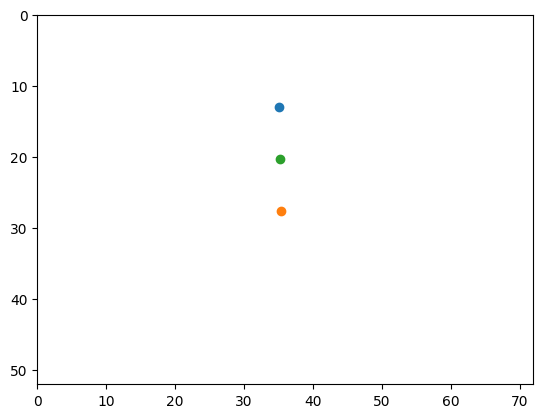

In [526]:
mx,my = midpoint(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'],row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'])
plt.scatter(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'])
plt.scatter(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'])
plt.scatter(mx,my)
plt.ylim([52,0]); plt.xlim([0, 72])

In [536]:
for ind,row in df.iterrows():
        if row['odd'] == False:
            points_x = np.zeros(len(row['head_angle']))
            points_y = np.zeros(len(row['head_angle']))
            obstacle_top= (row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'])
            obstacle_bottom=(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'])
            for indx,i in enumerate(row['head_angle']):
                current_ang= i
                mouse_x1 = row['ts_nose_x_cm'][indx]
                mouse_y1 = row['ts_nose_y_cm'][indx]
                mouse_x2 = mouse_x1-200 * np.cos(current_ang)
                mouse_y2 = mouse_y1-200* np.sin(current_ang)
                intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
                points_x[indx] = intersect_point[0]
                points_y[indx] = intersect_point[1]
        if row['odd'] == True:
            points_x = np.zeros(len(row['head_angle']))
            points_y = np.zeros(len(row['head_angle']))
            obstacle_top= (row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'])
            obstacle_bottom=(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'])
            for indx,i in enumerate(row['head_angle']):
                current_ang= i
                mouse_x1 = row['ts_nose_x_cm'][indx]
                mouse_y1 = row['ts_nose_y_cm'][indx]
                mouse_x2 = mouse_x1-200 * np.cos(current_ang)
                mouse_y2 = mouse_y1-200* np.sin(current_ang)
                intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
                points_x[indx] = intersect_point[0]
                points_y[indx] = intersect_point[1]
        #points_x = points_x[points_x!=0]
        #points_y = points_y[points_y!=0]
        df.at[ind,'obstacle_intersect_nose_x'] = points_x.astype(object)
        df.at[ind,'obstacle_intersect_nose_y'] = points_y.astype(object)

In [539]:
get_obstacle_intersect_body(df)

In [424]:
for ind,row in df.iterrows(df):
    if row['odd'] == False:
        points_x = np.zeros(len(row['head_angle']))
        points_y = np.zeros(len(row['head_angle']))
        obstacle_top= (row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'])
        obstacle_bottom=(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'])
        for indx,i in enumerate(row['head_angle']):
            current_ang= i
            mouse_x1 = row['ts_nose_x_cm'][indx]
            mouse_y1 = row['ts_nose_y_cm'][indx]
            mouse_x2 = mouse_x1-200 * np.cos(current_ang)
            mouse_y2 = mouse_y1-200* np.sin(current_ang)
            intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
            points_x[indx] = intersect_point[0]
            points_y[indx] = intersect_point[1]
    if row['odd'] == True:
        points_x = np.zeros(len(row['head_angle']))
        points_y = np.zeros(len(row['head_angle']))
        obstacle_top= (row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'])
        obstacle_bottom=(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'])
        for indx,i in enumerate(row['head_angle']):
            current_ang= i
            mouse_x1 = row['ts_nose_x_cm'][indx]
            mouse_y1 = row['ts_nose_y_cm'][indx]
            mouse_x2 = mouse_x1-200 * np.cos(current_ang)
            mouse_y2 = mouse_y1-200* np.sin(current_ang)
            intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
            points_x[indx] = intersect_point[0]
            points_y[indx] = intersect_point[1]
    points_x = points_x[points_x!=0]
    points_y = points_y[points_y!=0]
    df.at[ind,'obstacle_intersect_x'] = points_x.astype(object)
    df.at[ind,'obstacle_intersect_y'] = points_y.astype(object)



            





            


In [ ]:
obstacle_intersect_x

True


(0.0, 72.0)

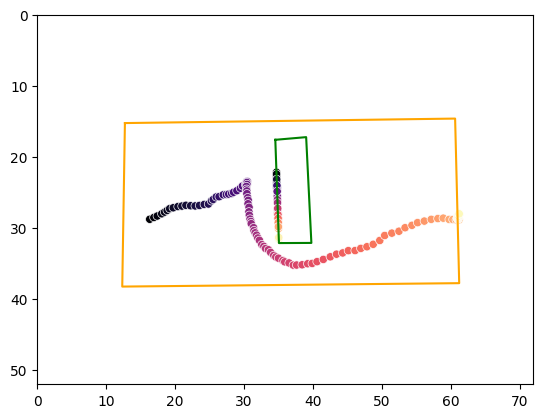

In [433]:

print(df.at[65,'odd'])
#plt.scatter(df.at[65,'obstacle_intersect_x'],df.at[65,'obstacle_intersect_y'],color = 'b')
sns.scatterplot(x=df.at[65,'obstacle_intersect_x'],y=df.at[65,'obstacle_intersect_y'],hue = df.at[65,'obstacle_intersect_y'], palette ='magma',legend=False) 

plt.plot([df.at[65,'arenaTL_x_cm'], df.at[65,'arenaTR_x_cm'], df.at[65,'arenaBR_x_cm'], df.at[65,'arenaBL_x_cm'],df.at[65,'arenaTL_x_cm']],
                [df.at[65,'arenaTL_y_cm'], df.at[65,'arenaTR_y_cm'], df.at[65,'arenaBR_y_cm'], df.at[65,'arenaBL_y_cm'],df.at[65,'arenaTL_y_cm']],color='orange')


plt.plot([df.at[65,'gt_obstacleTL_x_cm'], df.at[65,'gt_obstacleTR_x_cm'], df.at[65,'gt_obstacleBR_x_cm'], df.at[65,'gt_obstacleBL_x_cm'],df.at[65,'gt_obstacleTL_x_cm']],
                [df.at[65,'gt_obstacleTL_y_cm'], df.at[65,'gt_obstacleTR_y_cm'], df.at[65,'gt_obstacleBR_y_cm'], df.at[65,'gt_obstacleBL_y_cm'],df.at[65,'gt_obstacleTL_y_cm']],color='green')

sns.scatterplot(x=df.at[65,'ts_nose_x_cm'],y=df.at[65,'ts_nose_y_cm'],hue = enumerate(df.at[65,'ts_nose_x_cm']), palette ='magma',legend=False) 
 
plt.ylim([52,0]); plt.xlim([0, 72])


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 11.,  9., 13.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <BarContainer object of 10 artists>)

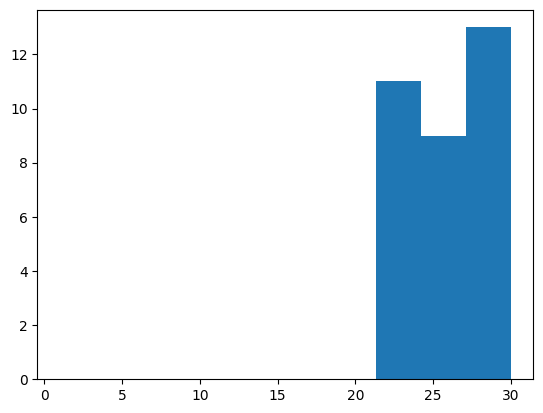

In [435]:
plt.hist(df.at[65,'obstacle_intersect_y'],range = [1,30])

(array([5., 6., 1., 3., 2., 3., 1., 1., 1., 2.]),
 array([33.57802941, 33.59411455, 33.61019969, 33.62628484, 33.64236998,
        33.65845513, 33.67454027, 33.69062541, 33.70671056, 33.7227957 ,
        33.73888084]),
 <BarContainer object of 10 artists>)

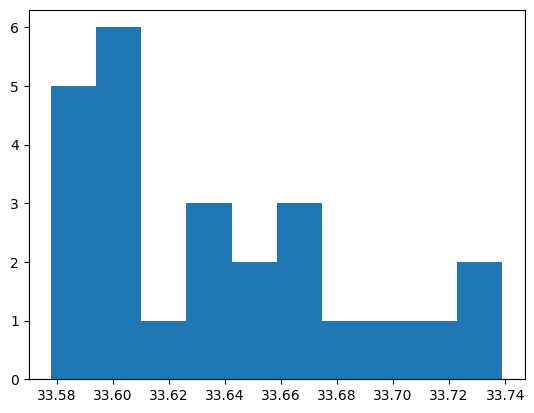

In [518]:
plt.hist(df.at[100,'obstacle_intersect_x'])

In [ ]:
    df.at[ind,'intersect_obstacle']=intersect_points.astype(object) 
    else:
        obstacle_top= (row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'])
        obstacle_bottom=(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'])
        for indx,i in enumerate(row['head_angle']):
            current_ang= i
            mouse_x1 = row['ts_nose_x_cm'][indx]
            mouse_y1 = row['ts_nose_y_cm'][indx]
            mouse_x2 = mouse_x1-200 * np.cos(current_ang)
            mouse_y2 = mouse_y1-200* np.sin(current_ang)
            intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)
            np.append(intersect_points,intersect_point)
    df.at[ind,'intersect_obstacle']=intersect_points.astype(object)
    
    


        



    
   #  current_ang = row[7,'head_angle'][ind]
   # mouse_x1 = cluster_2_odd.at[7,'ts_nose_x_cm'][ind]
   # mouse_y1 = cluster_2_odd.at[7,'ts_nose_y_cm'][ind]
   # mouse_x2 = mouse_x1-200 * np.cos(current_ang)
   # mouse_y2 = mouse_y1-200* np.sin(current_ang)
    


    

In [305]:
intersect_point=intersect((mouse_x1,mouse_y1),(mouse_x2,mouse_y2),obstacle_top,obstacle_bottom)

In [306]:
intersect_point

(30.709048671251317, 29.90427609925669)

In [ ]:
plt.plot([cluster_2_even.at[7,'arenaTL_x_cm'], cluster_2_even.at[7,'arenaTR_x_cm'], cluster_2_even.at[7,'arenaBR_x_cm'], cluster_2_even.at[7,'arenaBL_x_cm'],cluster_2_even.at[7,'arenaTL_x_cm']],
                [cluster_2_even.at[7,'arenaTL_y_cm'], cluster_2_even.at[7,'arenaTR_y_cm'], cluster_2_even.at[7,'arenaBR_y_cm'], cluster_2_even.at[7,'arenaBL_y_cm'],cluster_2_even.at[7,'arenaTL_y_cm']],color='orange')


plt.plot([cluster_2_even.at[7,'gt_obstacleTL_x_cm'], cluster_2_even.at[7,'gt_obstacleTR_x_cm'], cluster_2_even.at[7,'gt_obstacleBR_x_cm'], cluster_2_even.at[7,'gt_obstacleBL_x_cm'],cluster_2_even.at[7,'gt_obstacleTL_x_cm']],
                [cluster_2_even.at[7,'gt_obstacleTL_y_cm'], cluster_2_even.at[7,'gt_obstacleTR_y_cm'], cluster_2_even.at[7,'gt_obstacleBR_y_cm'], cluster_2_even.at[7,'gt_obstacleBL_y_cm'],cluster_2_even.at[7,'gt_obstacleTL_y_cm']],color='green')

plt.plot([cluster_2_even.at[7,'ts_nose_x_cm'][7],cluster_2_even.at[7,'ts_rightear_x_cm'][7],cluster_2_even.at[7,'ts_leftear_x_cm'][7],cluster_2_even.at[7,'ts_nose_x_cm'][7]],
[cluster_2_even.at[7,'ts_nose_y_cm'][7],cluster_2_even.at[7,'ts_rightear_y_cm'][7],cluster_2_even.at[7,'ts_leftear_y_cm'][7],cluster_2_even.at[7,'ts_nose_y_cm'][7]],color = 'green')

#for ind,i in enumerate(cluster_2_even.at[7,'head_angle']):

current_ang = i
x1 = cluster_2_even.at[7,'ts_nose_x_cm'][7]
y1 = cluster_2_even.at[7,'ts_nose_y_cm'][7]
x2 = x1-2 * np.cos(current_ang)
y2 = y1-2* np.sin(current_ang)
plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
#plt.scatter(x1,y1,color = 'r',marker = '.')
plt.scatter(x2,y2,color = 'b',marker = '<')
#sns.scatterplot(x=(x1,x2),y=(y1,y2),hue = enumerate(cluster_2_even.at[7,'ts_nose_x_cm']),palette ='magma',legend=False)

    

    
plt.scatter(cluster_2_even.at[7,'gt_obstacleTL_x_cm'],cluster_2_even.at[7,'gt_obstacleTL_y_cm'],color = 'blue')
plt.scatter(cluster_2_even.at[7,'gt_obstacleTR_x_cm'],cluster_2_even.at[7,'gt_obstacleTR_y_cm'],color = 'red')
plt.scatter(cluster_2_even.at[7,'gt_obstacleBL_x_cm'],cluster_2_even.at[7,'gt_obstacleBL_y_cm'],color = 'orange')
plt.scatter(cluster_2_even.at[7,'gt_obstacleBR_x_cm'],cluster_2_even.at[7,'gt_obstacleBR_y_cm'],color = 'green')
plt.scatter(cluster_2_even.at[7,'gt_obstacle_cen_x_cm'],cluster_2_even.at[7,'gt_obstacle_cen_y_cm'],color='blue')
plt.scatter(cluster_2_even.at[7,'leftportT_x_cm'],cluster_2_even.at[7,'leftportT_y_cm'],color='blue')
plt.scatter(cluster_2_even.at[7,'rightportT_x_cm'],cluster_2_even.at[7,'rightportT_y_cm'],color='black')
sns.scatterplot(x=cluster_2_even.at[7,'ts_nose_x_cm'],y=cluster_2_even.at[7,'ts_nose_y_cm'],hue = enumerate(cluster_2_even.at[7,'ts_nose_x_cm']), palette ='magma',legend=False) 
plt.scatter(cluster_2_even.at[7,'ts_nose_x_cm'][7],cluster_2_even.at[7,'ts_nose_y_cm'][7],color='c')  
#plt.scatter(cluster_2_even.at[7,'wobstacle_x_cm'], cluster_2_even.at[7,'wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ cluster_2_even.at[7,'obstacle_cluster']])
plt.ylim([52,0]); plt.xlim([0, 72])

In [314]:
intersect_point[0]

30.709048671251317

(0.0, 72.0)

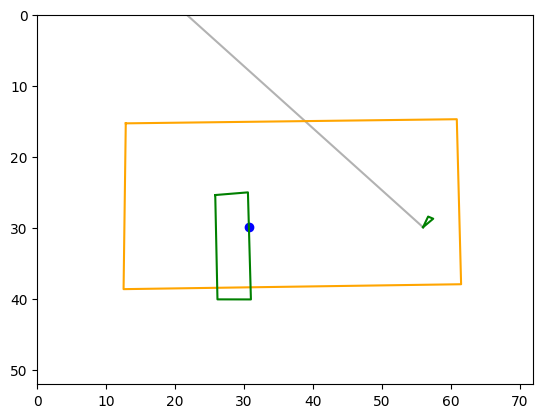

In [323]:
#plt.plot(x[0][0],x[0][1])
current_ang = [7,'head_angle'][0]
ind = 0
mouse_x1 = cluster_2_even.at[7,'ts_nose_x_cm'][ind]
mouse_y1 = cluster_2_even.at[7,'ts_nose_y_cm'][ind]
mouse_x2 = mouse_x1-100 * np.cos(current_ang)
mouse_y2 = mouse_y1-100* np.sin(current_ang)
plt.plot((mouse_x1,mouse_x2), (mouse_y1,mouse_y2), '-',color = 'black',alpha=0.3)
plt.scatter(intersect_point[0],intersect_point[1],color = 'b')
plt.plot([cluster_2_even.at[7,'arenaTL_x_cm'], cluster_2_even.at[7,'arenaTR_x_cm'], cluster_2_even.at[7,'arenaBR_x_cm'], cluster_2_even.at[7,'arenaBL_x_cm'],cluster_2_even.at[7,'arenaTL_x_cm']],
                [cluster_2_even.at[7,'arenaTL_y_cm'], cluster_2_even.at[7,'arenaTR_y_cm'], cluster_2_even.at[7,'arenaBR_y_cm'], cluster_2_even.at[7,'arenaBL_y_cm'],cluster_2_even.at[7,'arenaTL_y_cm']],color='orange')


plt.plot([cluster_2_even.at[7,'gt_obstacleTL_x_cm'], cluster_2_even.at[7,'gt_obstacleTR_x_cm'], cluster_2_even.at[7,'gt_obstacleBR_x_cm'], cluster_2_even.at[7,'gt_obstacleBL_x_cm'],cluster_2_even.at[7,'gt_obstacleTL_x_cm']],
                [cluster_2_even.at[7,'gt_obstacleTL_y_cm'], cluster_2_even.at[7,'gt_obstacleTR_y_cm'], cluster_2_even.at[7,'gt_obstacleBR_y_cm'], cluster_2_even.at[7,'gt_obstacleBL_y_cm'],cluster_2_even.at[7,'gt_obstacleTL_y_cm']],color='green')

plt.plot([cluster_2_even.at[7,'ts_nose_x_cm'][0],cluster_2_even.at[7,'ts_rightear_x_cm'][0],cluster_2_even.at[7,'ts_leftear_x_cm'][0],cluster_2_even.at[7,'ts_nose_x_cm'][0]],
[cluster_2_even.at[7,'ts_nose_y_cm'][0],cluster_2_even.at[7,'ts_rightear_y_cm'][0],cluster_2_even.at[7,'ts_leftear_y_cm'][0],cluster_2_even.at[7,'ts_nose_y_cm'][0]],color = 'green')
 
plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
# Find where head angle line intersect with facing wall of obstacle 

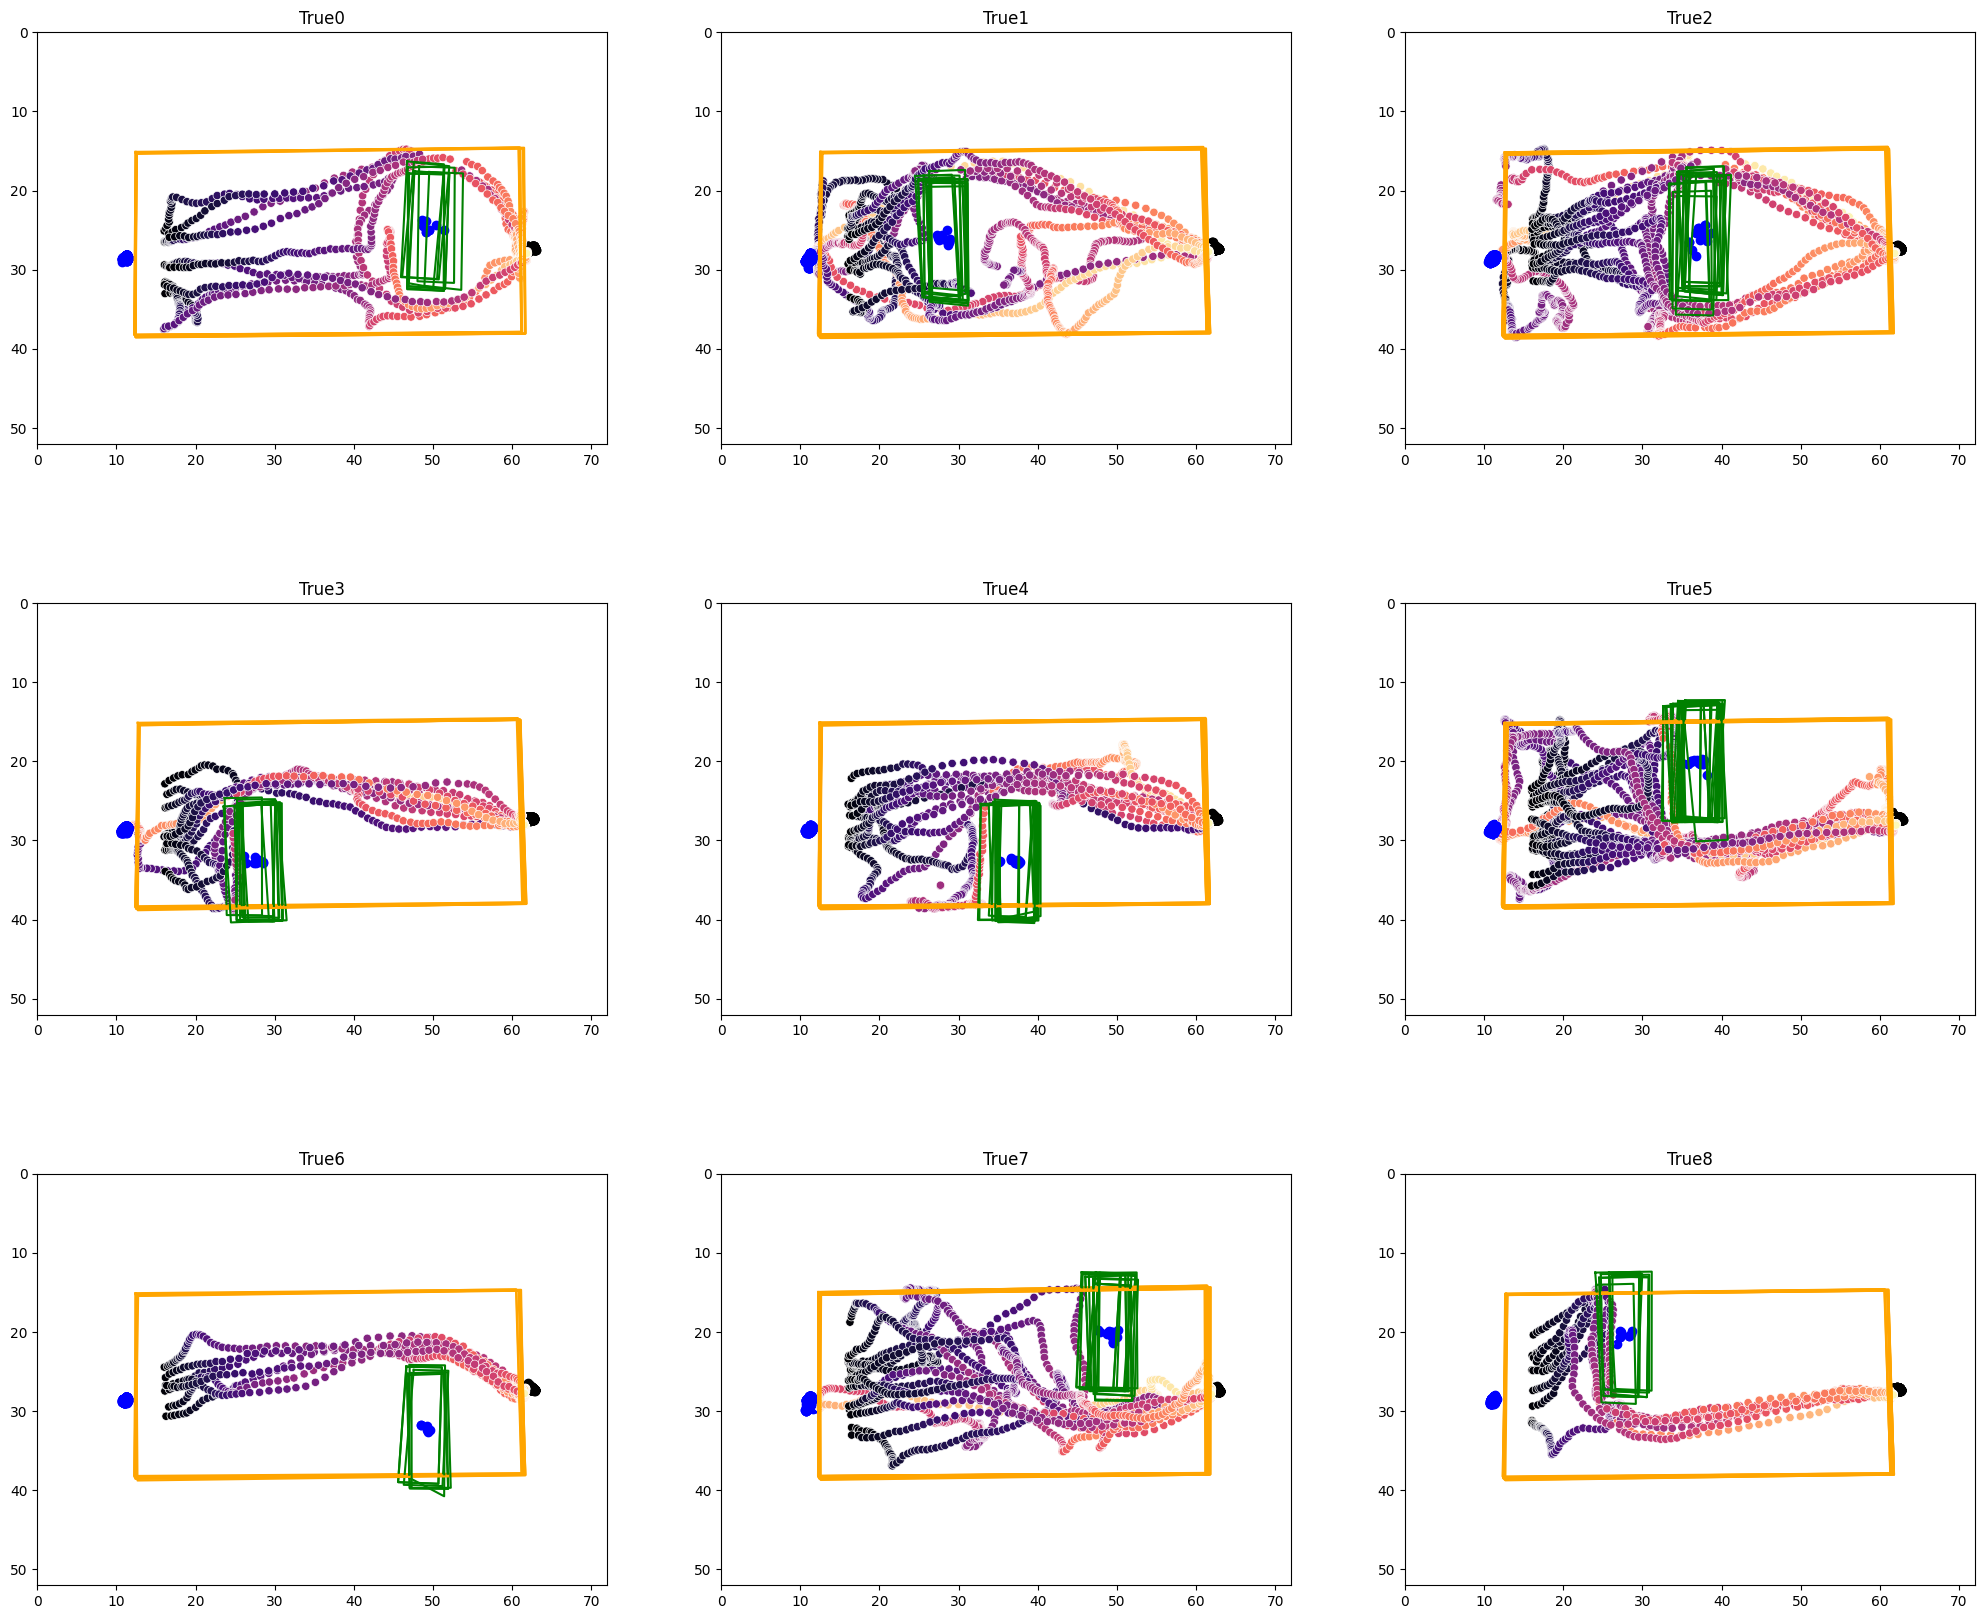

In [129]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(df['obstacle_cluster'].unique()):
    x=df.loc[df['obstacle_cluster']==cluster_name]
    for i, row in x.iterrows():
        if row['odd'] == True:
            plt.subplot(3,3,cluster_name+1)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))
    
            plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')


            plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
    
   
    
    
            plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
            plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
            plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
            sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
            #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
            plt.ylim([52,0]); plt.xlim([0, 72])

In [101]:
for ind, animal in enumerate(df['animal'].unique()): 
    print(ind,animal)

0 J19LT
1 J19RT
2 J20LT
3 J20RT


In [100]:
odd['animal'].unique()

array(['J19LT', 'J19RT', 'J20LT', 'J20RT'], dtype=object)

In [102]:
animal_df['obstacle_cluster'].unique()

array([2, 8, 3, 0, 4, 1, 7, 6])

In [98]:
odd = df[df['odd']==True]
even = df[df['odd']==False] 

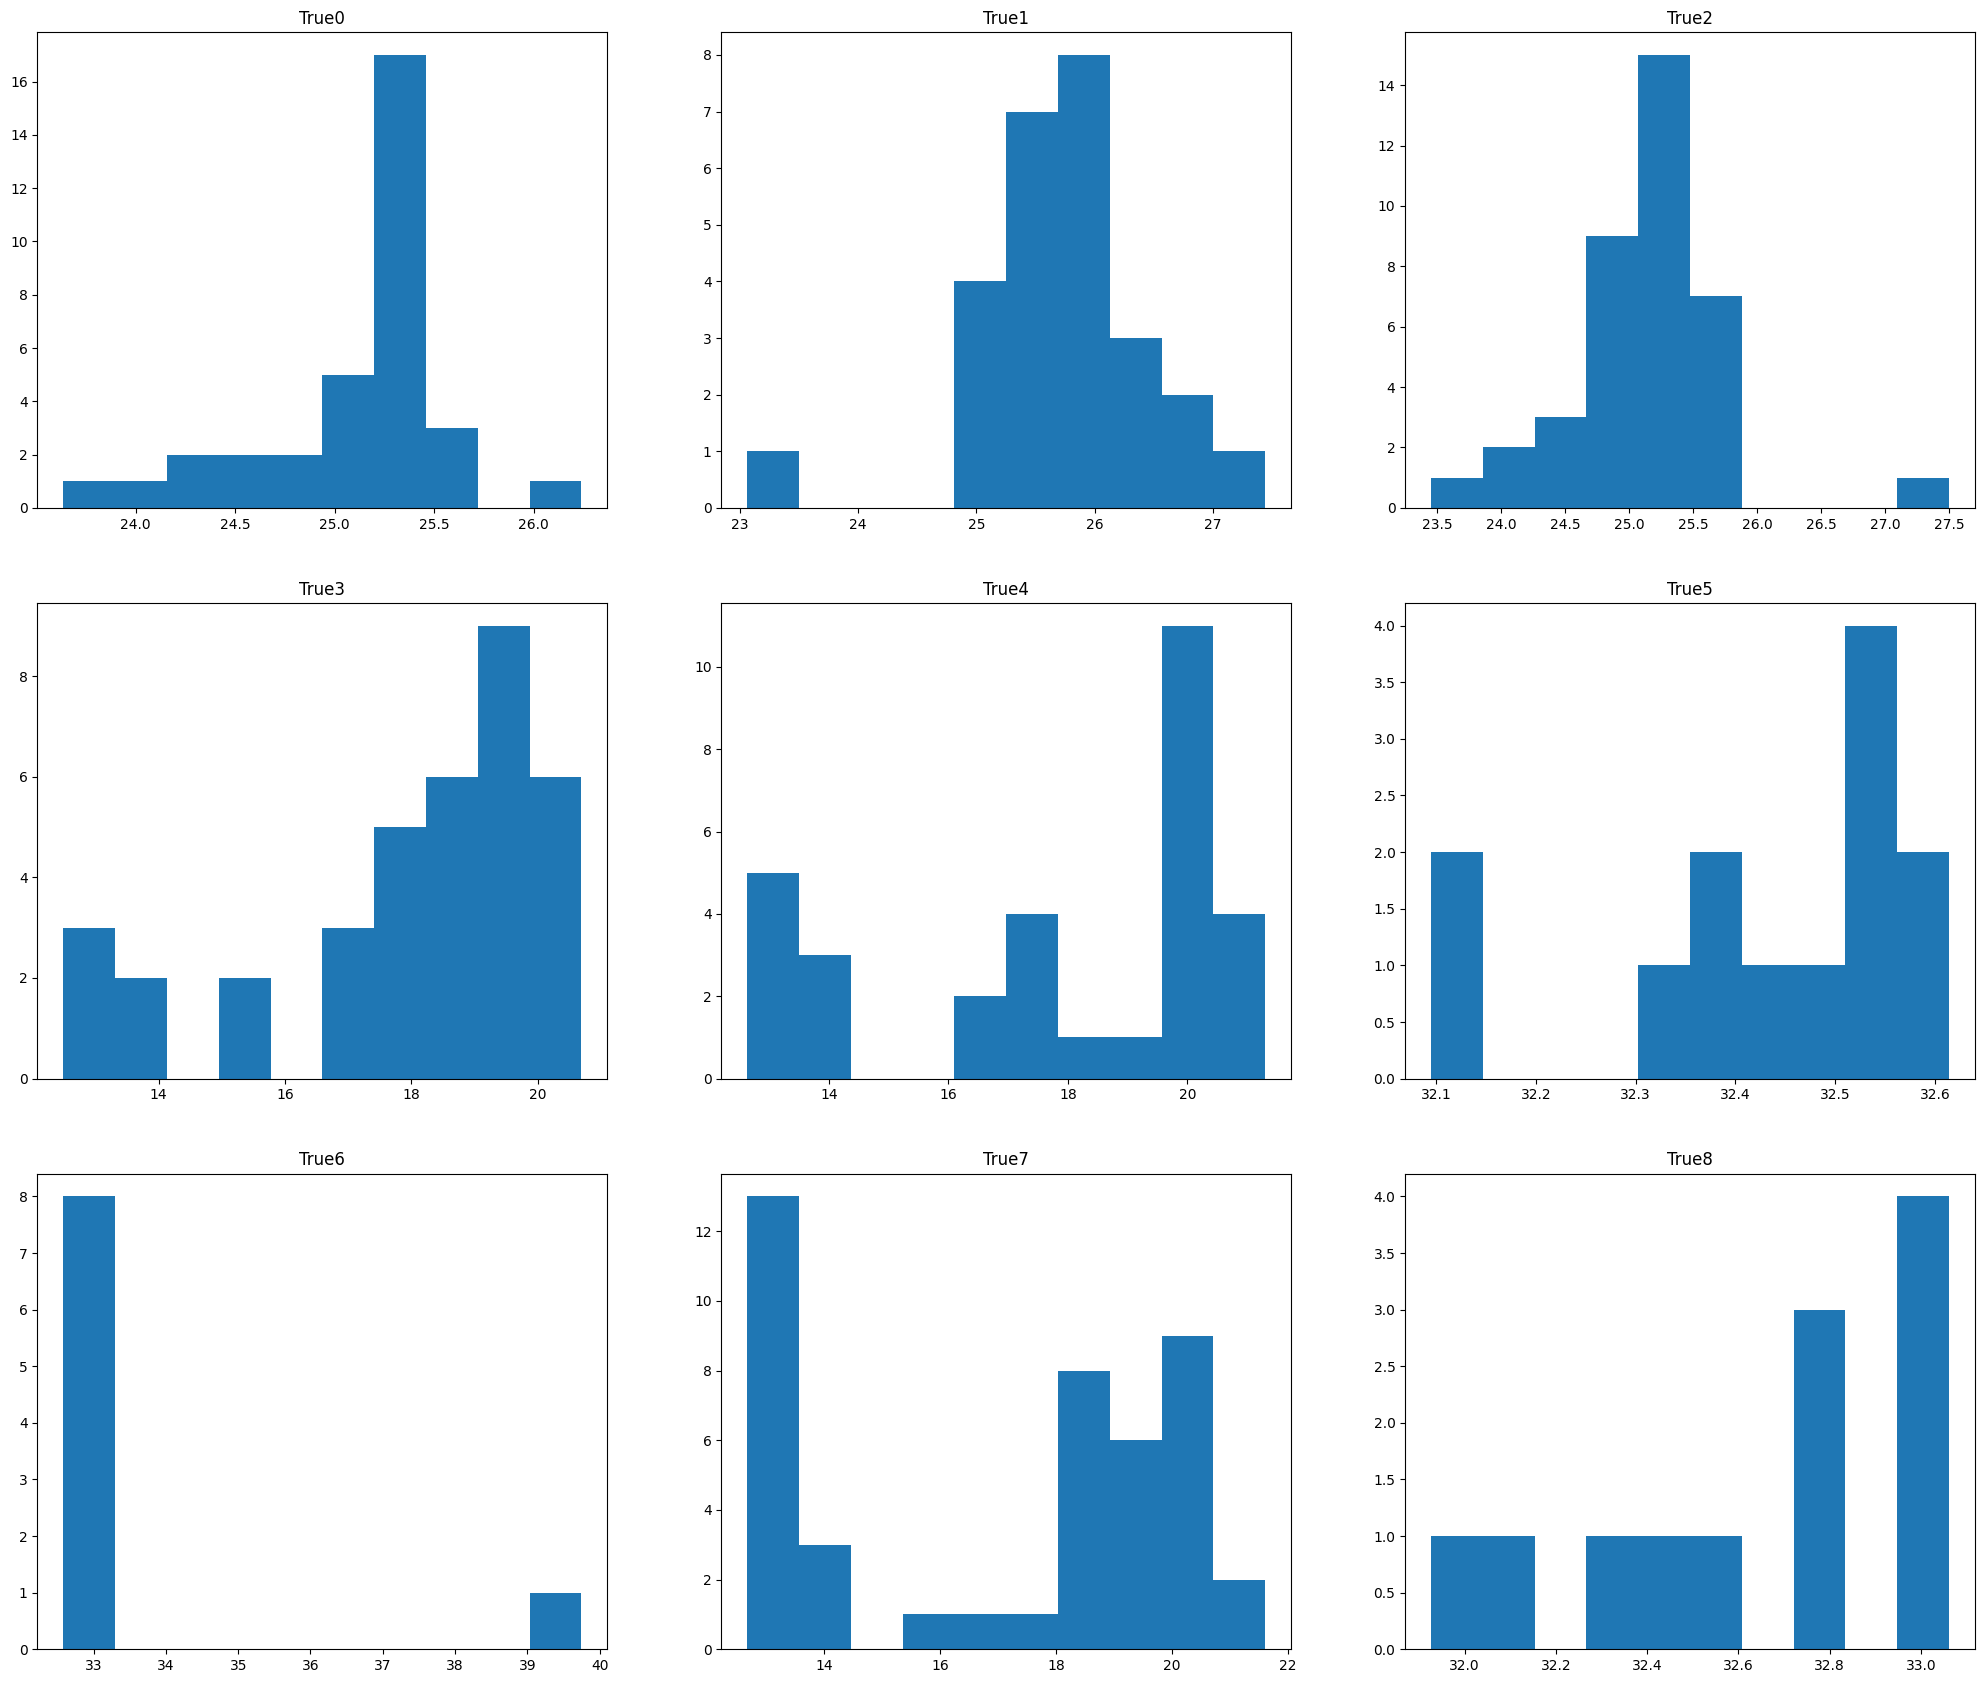

In [105]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(odd['obstacle_cluster'].unique()):
    x=odd.loc[odd['obstacle_cluster']==cluster_name]
    x= x.reset_index()
    
    plt.subplot(3,3,cluster_name+1)
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_title(str(x.at[1,'odd'])+str(x.at[1,'obstacle_cluster']))
    plt.hist(x['gt_obstacle_cen_y_cm'])

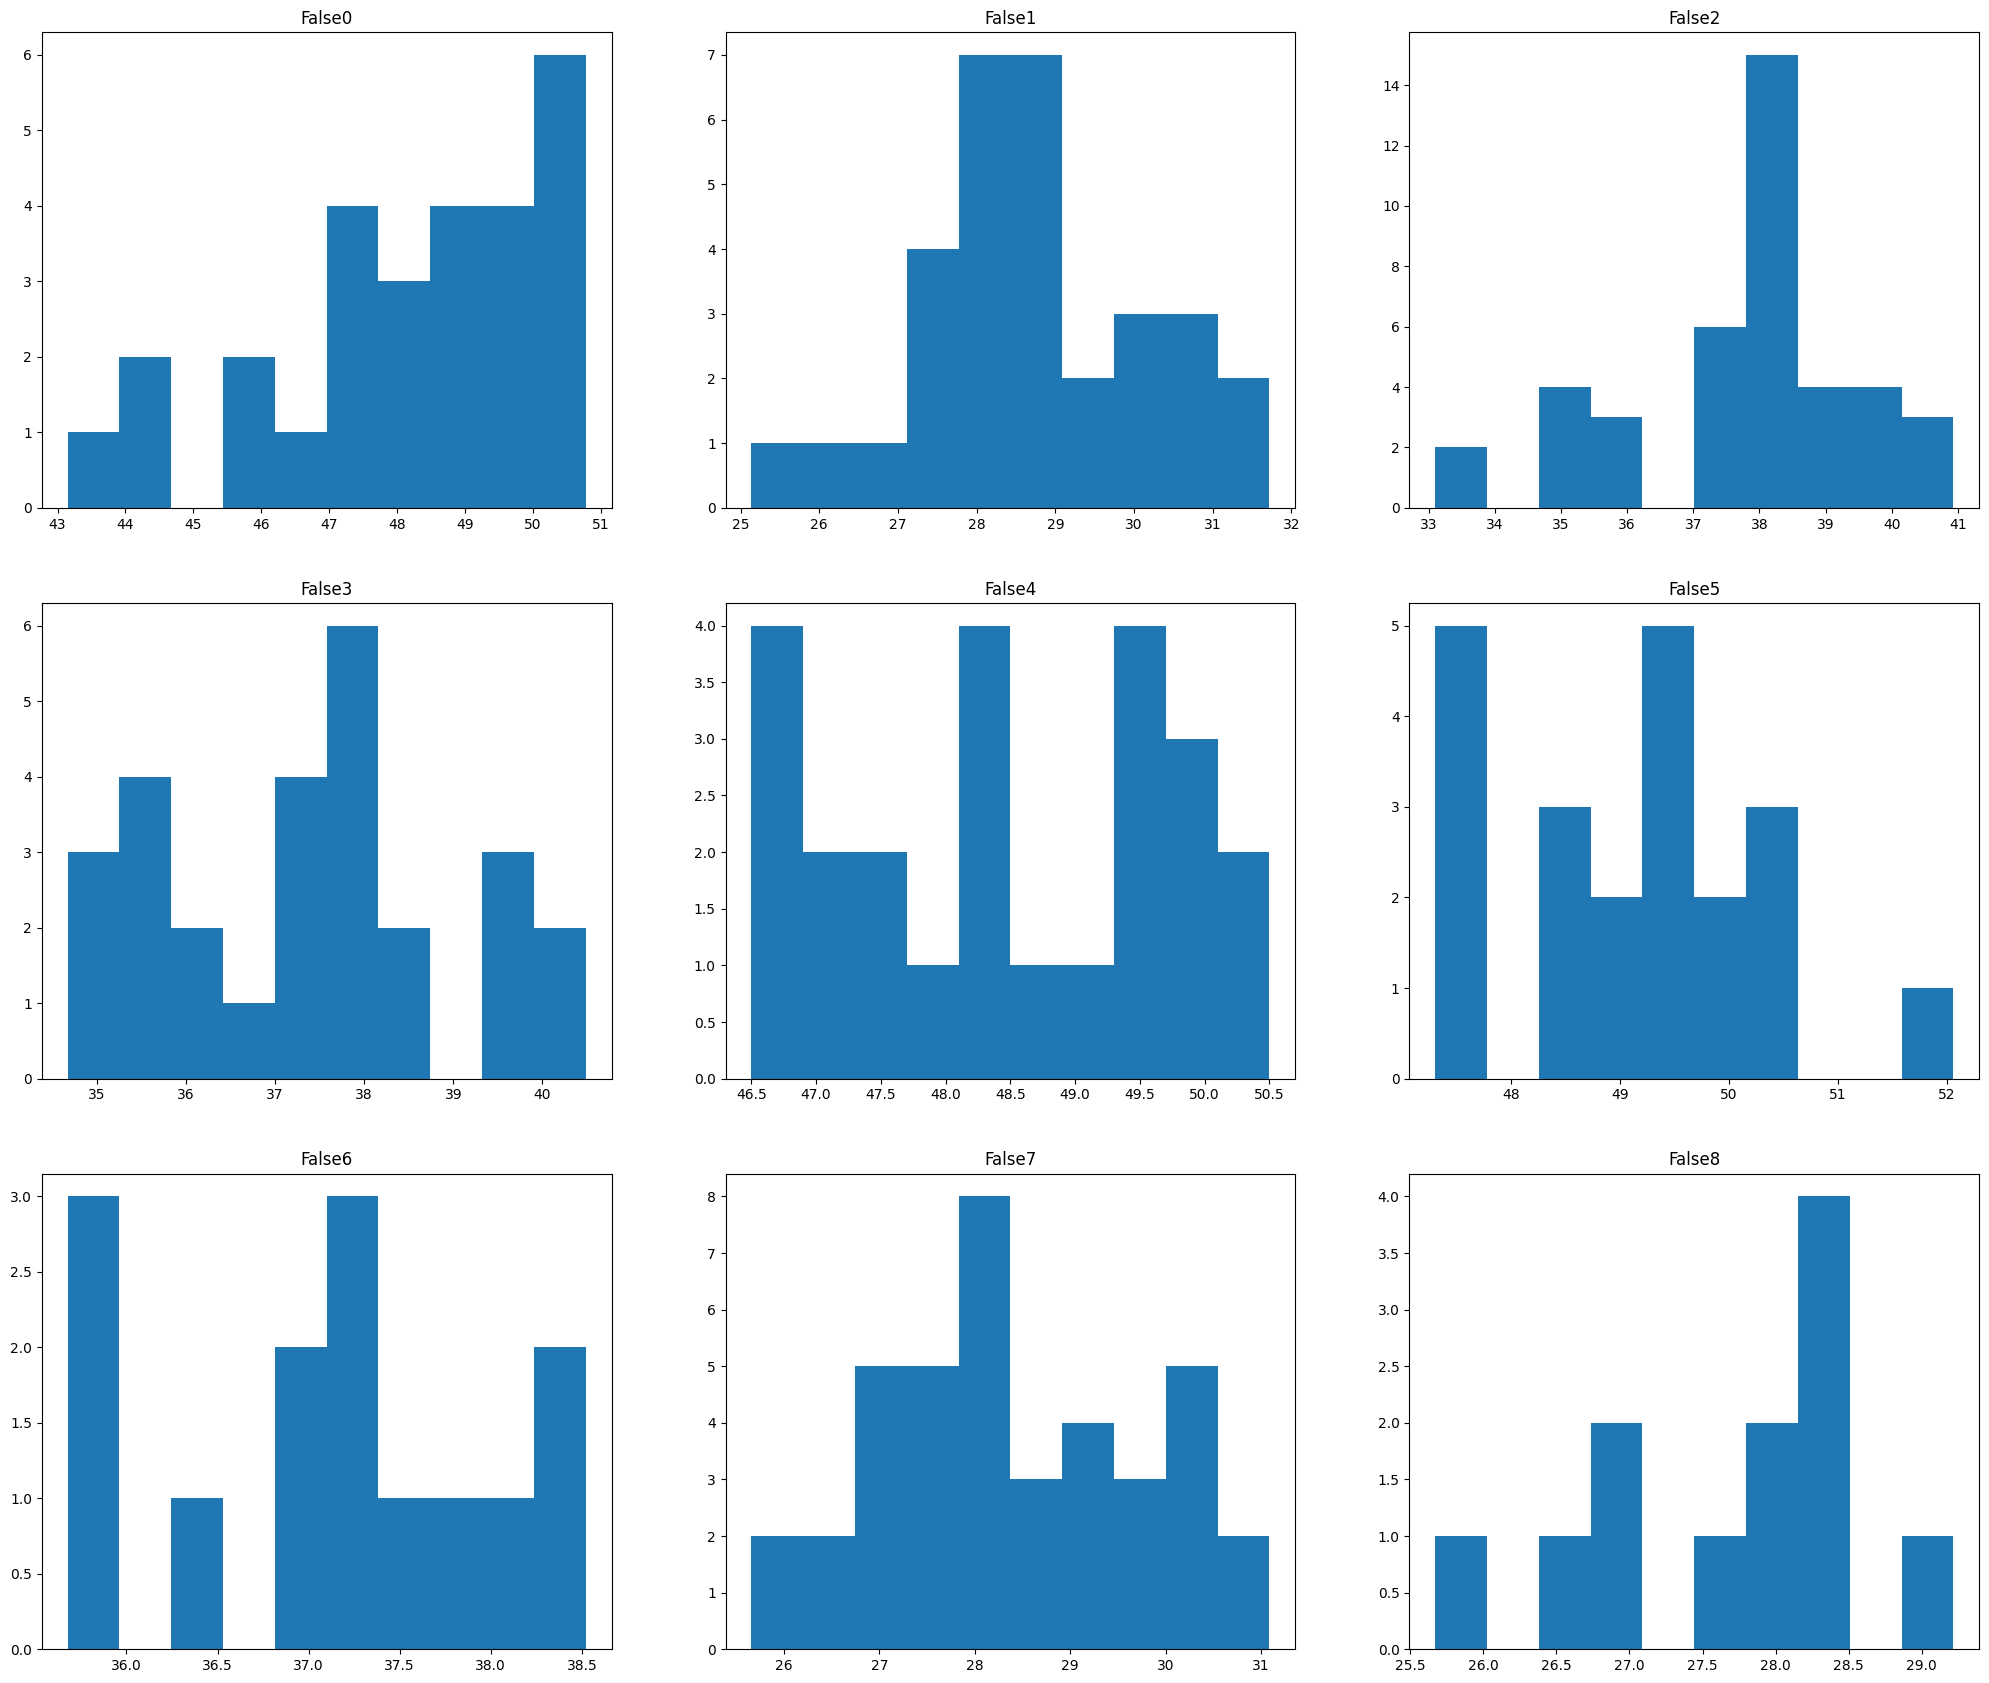

In [94]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(even['obstacle_cluster'].unique()):
    x=even.loc[even['obstacle_cluster']==cluster_name]
    x= x.reset_index()
    
    plt.subplot(3,3,cluster_name+1)
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_title(str(x.at[1,'odd'])+str(x.at[1,'obstacle_cluster']))
    plt.hist(x['gt_obstacle_cen_x_cm'])